<a href="https://colab.research.google.com/github/nazzang49/kaggle-practice/blob/main/practice01_A_Large_Scale_Fish_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Large Scale Fish Dataset
- (Theme) Classification
- (Library) PyTorch and Torchvision
- (Model) ResNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import gc

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)
print(device)

cuda


## Load Dataset and Transform

In [4]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

'''
    Root Location Ex:
        dataset/
            1/
                000001.jpg
                000002.jpg
            2/
                000001.jpg
                000002.jpg
'''
root = '/content/drive/MyDrive/data/fish'
dataset = ImageFolder(root=root, transform=transform)

# train and test split
total_count = len(dataset)
train_count = (int) (0.8 * total_count)
test_count = (int) (0.2 * total_count)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_count, test_count))
print(train_dataset)
print(test_dataset)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [6]:
import matplotlib.pyplot as plt

def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

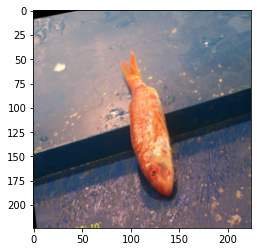

tensor(3)


In [7]:
# check image and label
for i, (inputs, labels) in enumerate(train_loader):
    custom_imshow(inputs[0])
    print(labels[0])
    break

## ResNet Architecture

In [8]:
import torchvision.models.resnet as resnet

In [9]:
# set conv1x1 / BasicBlock / Bottleneck
conv1x1 = resnet.conv1x1
basicblock = resnet.BasicBlock
bottleneck = resnet.Bottleneck

In [10]:
# custom model class
class ResNet(nn.Module):
    def __init__(self, block, layers, nb_class=5, zero_init_residual=False):
        super(ResNet, self).__init__()
        
        '''
            Architecture of Network
        '''
        self.inplanes = 16
        
        # default layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
#         self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # bottleneck layers
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        # avg / fc
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # resize by 1 x 1
        self.fc = nn.Linear(128 * block.expansion, nb_class) # 128 * block.expansion => final length of channel
        
        '''
            Initialization of Weights
        '''
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, resnet.Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, resnet.BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
    '''
        Make Block with Sequential of Multi-Layers
    '''
    # block = bottleneck (object type)
    def _make_layer(self, block, planes, block_num, stride=1):
        downsample = None
        # if block == bottleneck => expansion = 4
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers) # layers size => changeable
        
    '''
        Calculation of Forward Propagation of Network
    '''

    def forward(self, x):
        # default layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
#         x = self.maxpool1(x)

        # bottleneck layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # avg / fc
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten before fc
        x = self.fc(x)

        return x

In [11]:
resnet50 = ResNet(bottleneck, [3, 4, 6, 3], nb_class=5, zero_init_residual=True).to(device)
resnet50

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## Cost and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [19]:
def acc_check(net, test_loader, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            inputs = images.to(device)
            results = labels.to(device)
            
            outputs = net(inputs)
            _, prediction = torch.max(outputs.data, 1)
            
            total += results.size(0) # add batch_size
            correct += (prediction == results).sum().item() # correct prediction of batch_size
            
    acc = (100 * correct / total)
    print('Accuracy of the network on the test images: %d %%' % acc)
    if save:
        torch.save(net.state_dict(), "/content/drive/MyDrive/model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## Train

In [20]:
print(train_count)
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        inputs = images.to(device)
        results = labels.to(device)
        
        outputs = resnet50(inputs)
        loss = criterion(outputs, results)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    
    lr_sche.step() # lr_schedule step after every epoch
    
    # check acc after every epoch
    acc = acc_check(resnet50, test_loader, epoch, save=1)

1200
[1,    50] loss: 0.929
[1,   100] loss: 0.740
[1,   150] loss: 0.626
Accuracy of the network on the test images: 75 %
[2,    50] loss: 0.748
[2,   100] loss: 0.650
[2,   150] loss: 0.750
Accuracy of the network on the test images: 73 %
[3,    50] loss: 0.741
[3,   100] loss: 0.583
[3,   150] loss: 0.668
Accuracy of the network on the test images: 74 %
[4,    50] loss: 0.660
[4,   100] loss: 0.647
[4,   150] loss: 0.543
Accuracy of the network on the test images: 81 %
[5,    50] loss: 0.612
[5,   100] loss: 0.433
[5,   150] loss: 0.642
Accuracy of the network on the test images: 77 %
[6,    50] loss: 0.641
[6,   100] loss: 0.460
[6,   150] loss: 0.550
Accuracy of the network on the test images: 84 %
[7,    50] loss: 0.449
[7,   100] loss: 0.354
[7,   150] loss: 0.459
Accuracy of the network on the test images: 82 %
[8,    50] loss: 0.405
[8,   100] loss: 0.485
[8,   150] loss: 0.407
Accuracy of the network on the test images: 85 %
[9,    50] loss: 0.387
[9,   100] loss: 0.500
[9,  